In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **Face Recognition**

# **LAB-1 --> HOG**

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Step 1: Function to extract HOG features
def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """
    Extract HOG features from a single image.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, hog_image = hog(
        gray_image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm="L2-Hys",
        visualize=True,
    )
    return features

# Step 2: Function to preprocess dataset with HOG
def load_and_preprocess_with_hog(folder_path, img_size=(128,128)):
    features = []
    labels = []
    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        for image_file in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image_resized = cv2.resize(image, img_size)
                hog_features = extract_hog_features(image_resized)
                features.append(hog_features)
                labels.append(label)
    return np.array(features), np.array(labels)

# Step 3: Main training process
if __name__ == "__main__":
    output_path = '/content/drive/MyDrive/FaceRecog/Split_Train'

    train_path = os.path.join(output_path, 'training')
    test_path = os.path.join(output_path, 'testing')
    val_path = os.path.join(output_path, 'validation')

    # Load and preprocess the dataset
    X_train, y_train = load_and_preprocess_with_hog(train_path)
    X_test, y_test = load_and_preprocess_with_hog(test_path)
    X_val, y_val = load_and_preprocess_with_hog(val_path)

        # Print the number of samples in each set
    print(f"Number of training samples: {X_train.shape[0]}")
    print(f"Number of testing samples: {X_test.shape[0]}")
    print(f"Number of validation samples: {X_val.shape[0]}")

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    y_val = label_encoder.transform(y_val)

    # Step 4: Build the DNN with 6 Layers
    model = Sequential()

    # Layer 1: Input layer
    model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Layer 2: Dense layer
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Layer 3: Dense layer
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Layer 4: Dense layer
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    # Layer 5: Dense layer
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Layer 6: Dense layer
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Layer 6: Output layer
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=200,
                        batch_size=32,
                        callbacks=[early_stopping, lr_scheduler])
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    #print(f"Train Accuracy: {train_accuracy * 100:.2f}")
    #print(f"Validation Accuracy: {val_accuracy * 100:.2f}")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Save the model
    model.save('/content/drive/MyDrive/HOGDNNFaceRecognitionModel_6Layers.keras')

Number of training samples: 2310
Number of testing samples: 762
Number of validation samples: 802


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 232ms/step - accuracy: 0.0302 - loss: 9.0230 - val_accuracy: 0.0237 - val_loss: 7.9906 - learning_rate: 1.0000e-04
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - accuracy: 0.0380 - loss: 8.8531 - val_accuracy: 0.0274 - val_loss: 8.0067 - learning_rate: 1.0000e-04
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.0341 - loss: 8.7546 - val_accuracy: 0.0287 - val_loss: 8.0031 - learning_rate: 1.0000e-04
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.0402 - loss: 8.6259 - val_accuracy: 0.0362 - val_loss: 7.9813 - learning_rate: 1.0000e-04
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.0414 - loss: 8.6084 - val_accuracy: 0.0561 - val_loss: 7.8922 - learning_rate: 1.0000e-04
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.0480 - loss: 8.4791 - val_accuracy: 0.0773 - val_loss: 7.8033 - learning_rate: 1.0000e-04
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/ste

In [ ]:
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 98.35
Testing Accuracy: 96.36


Clout

# **Spliting the files in Train 60,Test 20,Validation 20**

In [ ]:
import os
import shutil
import random

def split_images(source_folder, train_ratio=0.6, test_ratio=0.2, val_ratio=0.2):
    # Define the target directories
    train_folder = os.path.join(source_folder, 'training')
    test_folder = os.path.join(source_folder, 'testing')
    val_folder = os.path.join(source_folder, 'validation')

    # Create the target directories if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    # Iterate over each subfolder (class) in the source folder
    for class_name in os.listdir(source_folder):
        class_folder = os.path.join(source_folder, class_name)

        # Skip if it's not a directory
        if not os.path.isdir(class_folder) or class_name in ['training', 'testing', 'validation']:
            continue

        # Get the list of images in the class folder
        images = [img for img in os.listdir(class_folder) if img.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        random.shuffle(images)

        # Calculate the number of images for each set
        num_images = len(images)
        num_train = int(num_images * train_ratio)
        num_test = int(num_images * test_ratio)
        num_val = num_images - num_train - num_test

        # Split the images into training, testing, and validation sets
        train_images = images[:num_train]
        test_images = images[num_train:num_train + num_test]
        val_images = images[num_train + num_test:]

        # Function to copy images to the target directory
        def copy_images(image_list, target_folder):
            target_class_folder = os.path.join(target_folder, class_name)
            os.makedirs(target_class_folder, exist_ok=True)
            for img in image_list:
                shutil.copy(os.path.join(class_folder, img), os.path.join(target_class_folder, img))

        # Copy images to the respective folders
        copy_images(train_images, train_folder)
        copy_images(test_images, test_folder)
        copy_images(val_images, val_folder)

    print("Splitting completed successfully!")

# Example usage
source_folder = '/content/drive/MyDrive/FaceRecog/Split_Train'  # Replace with the path to your folder
split_images(source_folder)

Splitting completed successfully!


# **LAB-2a --> VGG16**

In [ ]:
#/content/drive/MyDrive/FaceRecog/Train'
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare Dataset Function
def prepare_dataset(dataset_path, img_size=(128, 128)):
    """
    Prepares dataset by resizing all images to the specified size.
    Args:
    - dataset_path (str): Path to dataset folder.
    - img_size (tuple): Desired size of images.
    Returns:
    - X (np.array): Array of resized images.
    - y (np.array): Array of labels.
    """
    data = []
    labels = []

    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    image = cv2.imread(file_path)
                    image = cv2.resize(image, img_size)  # Resize to desired size
                    data.append(image)
                    labels.append(folder_name)

    return np.array(data), np.array(labels)

# Function to create a custom VGG16-like model
def create_manual_vgg16(input_shape=(128, 128, 3), num_classes=31):
    """
    Creates a custom VGG16-like model by manually adding the layers.
    Args:
    - input_shape (tuple): Shape of input images.
    - num_classes (int): Number of output classes.
    Returns:
    - Sequential Model object.
    """
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu',kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu',kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Main Execution
if __name__ == "__main__":
    # Paths to the dataset
    dataset_path = '/content/drive/MyDrive/FaceRecog/Train'  # Path to your dataset folder

    # Prepare dataset
    print("Preparing dataset...")
    X, y = prepare_dataset(dataset_path)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create VGG16-like model
    model = create_manual_vgg16(input_shape=(128, 128, 3), num_classes=len(np.unique(y)))

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.15, callbacks=[early_stopping])

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Preparing dataset...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 324ms/step - accuracy: 0.0328 - loss: 351.9617 - val_accuracy: 0.0552 - val_loss: 205.2581
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step - accuracy: 0.0386 - loss: 173.5831 - val_accuracy: 0.0390 - val_loss: 99.2196
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.0440 - loss: 83.6211 - val_accuracy: 0.0325 - val_loss: 47.5464
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.0397 - loss: 40.1840 - val_accuracy: 0.0422 - val_loss: 23.2477
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.0603 - loss: 19.8000 - val_accuracy: 0.0455 - val_loss: 12.3120
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.0959 - loss: 10.6756 - val_accuracy: 0.1071 - val_loss: 7.3456
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.1623 - loss: 6.4771 - val_accuracy: 0.1786 - val_loss: 4.9875
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.1993 - loss: 4.5

# **LAB-2b --> DenseNet201**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder

# Step 1: Load and preprocess the dataset
def load_and_preprocess_images(folder_path, img_size=(224, 224)):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        for image_file in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Step 2: Load the dataset
train_path = "/content/drive/MyDrive/FaceRecog/Split_Train/training"
val_path = "/content/drive/MyDrive/FaceRecog/Split_Train/validation"
test_path = "/content/drive/MyDrive/FaceRecog/Split_Train/testing"

X_train, y_train = load_and_preprocess_images(train_path)
X_test, y_test = load_and_preprocess_images(test_path)
X_val, y_val = load_and_preprocess_images(val_path)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Step 3: Load the DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_densenet201_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Step 4: Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=50,
                    callbacks=[early_stopping, lr_scheduler, model_checkpoint])

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save('/content/drive/MyDrive/DenseNet201_FaceRecognition_Model.h5')

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.0629 - loss: 3.5444

73/73 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.0632 - loss: 3.5421 - val_accuracy: 0.2007 - val_loss: 2.9893 - learning_rate: 1.0000e-04
Epoch 2/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1880 - loss: 2.9545

73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.1880 - loss: 2.9540 - val_accuracy: 0.2506 - val_loss: 2.7537 - learning_rate: 1.0000e-04
Epoch 3/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2379 - loss: 2.7001

73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - accuracy: 0.2385 - loss: 2.6985 - val_accuracy: 0.3217 - val_loss: 2.5854 - learning_rate: 1.0000e-04
Epoch 4/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2956 - loss: 2.4794

73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.2959 - loss: 2.4786 - val_accuracy: 0.3878 - val_loss: 2.4537 - learning_rate: 1.0000e-04
Epoch 5/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3604 - loss: 2.3245

73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.3605 - loss: 2.3234 - val_accuracy: 0.4090 - val_loss: 2.3549 - learning_rate: 1.0000e-04
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.4067 - loss: 2.1200 - val_accuracy: 0.4065 - val_loss: 2.2953 - learning_rate: 1.0000e-04
Epoch 7/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4178 - loss: 2.0548

73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.4183 - loss: 2.0534 - val_accuracy: 0.4439 - val_loss: 2.2064 - learning_rate: 1.0000e-04
Epoch 8/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4721 - loss: 1.8939

73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.4723 - loss: 1.8936 - val_accuracy: 0.4539 - val_loss: 2.1415 - learning_rate: 1.0000e-04
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4949 - loss: 1.8117

73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.4951 - loss: 1.8113 - val_accuracy: 0.4663 - val_loss: 2.0904 - learning_rate: 1.0000e-04
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.5332 - loss: 1.7087 - val_accuracy: 0.4663 - val_loss: 2.0673 - learning_rate: 1.0000e-04
Epoch 11/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5274 - loss: 1.6774

73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.5281 - loss: 1.6760 - val_accuracy: 0.4850 - val_loss: 2.0182 - learning_rate: 1.0000e-04
Epoch 12/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5848 - loss: 1.5151

73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.5845 - loss: 1.5154 - val_accuracy: 0.5075 - val_loss: 1.9832 - learning_rate: 1.0000e-04
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.6143 - loss: 1.4435 - val_accuracy: 0.5037 - val_loss: 1.9429 - learning_rate: 1.0000e-04
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6407 - loss: 1.3873

73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.6406 - loss: 1.3873 - val_accuracy: 0.5150 - val_loss: 1.9164 - learning_rate: 1.0000e-04
Epoch 15/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.6712 - loss: 1.2810 - val_accuracy: 0.5150 - val_loss: 1.9019 - learning_rate: 1.0000e-04
Epoch 16/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6594 - loss: 1.2596

73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.6595 - loss: 1.2595 - val_accuracy: 0.5299 - val_loss: 1.8746 - learning_rate: 1.0000e-04
Epoch 17/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6907 - loss: 1.2035

73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.6906 - loss: 1.2040 - val_accuracy: 0.5362 - val_loss: 1.8551 - learning_rate: 1.0000e-04
Epoch 18/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6819 - loss: 1.1818

73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.6823 - loss: 1.1812 - val_accuracy: 0.5449 - val_loss: 1.8338 - learning_rate: 1.0000e-04
Epoch 19/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.7215 - loss: 1.0739 - val_accuracy: 0.5324 - val_loss: 1.8242 - learning_rate: 1.0000e-04
Epoch 20/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.7453 - loss: 1.0410 - val_accuracy: 0.5399 - val_loss: 1.8112 - learning_rate: 1.0000e-04
Epoch 21/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.7659 - loss: 0.9961 - val_accuracy: 0.5436 - val_loss: 1.8017 - learning_rate: 1.0000e-04
Epoch 22/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.7420 - loss: 1.0055 - val_accuracy: 0.5387 - val_loss: 1.7881 - learning_rate: 1.0000e-04
Epoch 23/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.7701 - loss: 0.9259 - val_accuracy: 0.5449 - val_loss: 1.7851 - learning_rate: 1.0000e-04
Epoch 24/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy:

73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.7867 - loss: 0.9052 - val_accuracy: 0.5561 - val_loss: 1.7696 - learning_rate: 1.0000e-04
Epoch 25/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.8025 - loss: 0.8577 - val_accuracy: 0.5549 - val_loss: 1.7645 - learning_rate: 1.0000e-04
Epoch 26/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.8003 - loss: 0.8200 - val_accuracy: 0.5436 - val_loss: 1.7613 - learning_rate: 1.0000e-04
Epoch 27/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.8102 - loss: 0.8044 - val_accuracy: 0.5474 - val_loss: 1.7495 - learning_rate: 1.0000e-04
Epoch 28/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.8386 - loss: 0.7338 - val_accuracy: 0.5499 - val_loss: 1.7433 - learning_rate: 1.0000e-04
Epoch 29/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8245 - loss: 0.7787

73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.8249 - loss: 0.7780 - val_accuracy: 0.5661 - val_loss: 1.7400 - learning_rate: 1.0000e-04
Epoch 30/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.8536 - loss: 0.6958 - val_accuracy: 0.5611 - val_loss: 1.7231 - learning_rate: 1.0000e-04
Epoch 31/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.8388 - loss: 0.6964 - val_accuracy: 0.5599 - val_loss: 1.7294 - learning_rate: 1.0000e-04
Epoch 32/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.8527 - loss: 0.6815 - val_accuracy: 0.5648 - val_loss: 1.7227 - learning_rate: 1.0000e-04
Epoch 33/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.8539 - loss: 0.6389 - val_accuracy: 0.5611 - val_loss: 1.7251 - learning_rate: 1.0000e-04
Epoch 34/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.8713 - loss: 0.5997 - val_accuracy: 0.5561 - val_loss: 1.7145 - learning_rate: 1.0000e-04
Epoch 35/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy:

73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.8907 - loss: 0.5817 - val_accuracy: 0.5711 - val_loss: 1.7055 - learning_rate: 1.0000e-04
Epoch 36/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8793 - loss: 0.5724

73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.8793 - loss: 0.5724 - val_accuracy: 0.5786 - val_loss: 1.7017 - learning_rate: 1.0000e-04
Epoch 37/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.8879 - loss: 0.5648 - val_accuracy: 0.5723 - val_loss: 1.7096 - learning_rate: 1.0000e-04
Epoch 38/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.8988 - loss: 0.5194 - val_accuracy: 0.5748 - val_loss: 1.7023 - learning_rate: 1.0000e-04
Epoch 39/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.8978 - loss: 0.5123 - val_accuracy: 0.5723 - val_loss: 1.7059 - learning_rate: 1.0000e-04
Epoch 40/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9003 - loss: 0.5127

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.9004 - loss: 0.5125 - val_accuracy: 0.5823 - val_loss: 1.6970 - learning_rate: 1.0000e-04
Epoch 41/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.9077 - loss: 0.5002 - val_accuracy: 0.5698 - val_loss: 1.7072 - learning_rate: 1.0000e-04
Epoch 42/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.9124 - loss: 0.4592 - val_accuracy: 0.5748 - val_loss: 1.6983 - learning_rate: 1.0000e-04
Epoch 43/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.9158 - loss: 0.4374 - val_accuracy: 0.5798 - val_loss: 1.7001 - learning_rate: 1.0000e-04
Epoch 44/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.9129 - loss: 0.4254 - val_accuracy: 0.5823 - val_loss: 1.7011 - learning_rate: 1.0000e-04
Epoch 45/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9234 - loss: 0.4225
Epoch 45: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.92

Test Accuracy: 53.54%


# **LAB-2c --> XceptionNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.utils import to_categorical
import os
import cv2
from sklearn.preprocessing import LabelEncoder

# Paths to pre-split data
train_dir = "/content/drive/MyDrive/FaceRecog/Split_Train/training"
val_dir = "/content/drive/MyDrive/FaceRecog/Split_Train/validation"
test_dir = "/content/drive/MyDrive/FaceRecog/Split_Train/testing"

# Function to load images from directory
def load_data(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_folder = os.path.join(directory, class_name)
        if not os.path.isdir(class_folder):
            continue
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            image = cv2.imread(image_path)
            if image is None:
                continue
            image = cv2.resize(image, (128, 128))  # Updated image size to 128x128
            images.append(image)
            labels.append(class_name)
    return np.array(images) / 255.0, np.array(labels), class_names

# Load datasets
X_train, y_train, class_names = load_data(train_dir)
X_val, y_val, _ = load_data(val_dir)
X_test, y_test, _ = load_data(test_dir)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(class_names)
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=len(class_names))
y_val_one_hot = to_categorical(y_val_encoded, num_classes=len(class_names))
y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(class_names))

# Load pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  # Using pre-trained weights

# Freeze base model layers
base_model.trainable = False

# Custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
epochs = 100
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=epochs)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.0986 - loss: 3.3598 - val_accuracy: 0.2718 - val_loss: 2.6651
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2598 - loss: 2.5435 - val_accuracy: 0.3067 - val_loss: 2.4282
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.3762 - loss: 2.1922 - val_accuracy: 0.3766 - val_loss: 2.2957
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.4645 - loss: 1.8960 - val_accuracy: 0.3828 - val_loss: 2.2336
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.4781 - loss: 1.7792 - val_accuracy: 0.3915 - val_loss: 2.2008
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5586 - loss: 1.5401 - val_accuracy: 0.4214 - val_loss: 2.1374
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5815 - loss: 1.4401 - val_accuracy: 0.4364 - val_loss: 2.1372
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step

# Breast Cancer

# **Data Unzip**

In [ ]:
zip_path = "/content/drive/MyDrive/Speech Dataset/train.7z"
extract_path = "/content/drive/MyDrive/Speech Dataset"

**Extract Tar file**

In [ ]:
import os

# Extract tar.gz file
os.system(f"tar -xvzf '{file_path}' -C '{extract_path}'")

**Extract Zip File**

In [ ]:
import zipfile
import os

# Ensure the extraction folder exists
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction Complete! ✅")

**for .7z**

In [ ]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 27.5 MB/s eta 0:00:00


In [ ]:
import py7zr
import os

In [ ]:
os.makedirs(extract_path, exist_ok=True)

with py7zr.SevenZipFile(zip_path, mode='r') as z:
    z.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


# **File Preprocessing**

In [ ]:
import os
import shutil

# Path to the main folder
main_folder = "/content/drive/MyDrive/breast cnacer/kaggle"  # Replace with the actual path to your main folder

# Paths to the destination folders
not_cancer_folder = "/content/drive/MyDrive/breast cnacer/Not Cancer"  # Replace with the actual path for "Not Cancer"
cancer_folder = "/content/drive/MyDrive/breast cnacer/Cancer"         # Replace with the actual path for "Cancer"

# Create destination folders if they don't exist
os.makedirs(not_cancer_folder, exist_ok=True)
os.makedirs(cancer_folder, exist_ok=True)

# Function to copy files from source to destination
def copy_files(source_folder, destination_folder, num_files=50):
    if not os.path.exists(source_folder):
        print(f"Source folder does not exist: {source_folder}")
        return

    # Get all files in the source folder
    files = os.listdir(source_folder)
    for i in range(min(num_files, len(files))):  # Copy only the first `num_files`
        source_file = os.path.join(source_folder, files[i])
        dest_file = os.path.join(destination_folder, files[i])

        # Ensure unique filenames in the destination folder
        counter = 1
        while os.path.exists(dest_file):
            base_name, ext = os.path.splitext(files[i])
            dest_file = os.path.join(destination_folder, f"{base_name}_{counter}{ext}")
            counter += 1

        # Copy the file
        shutil.copy(source_file, dest_file)
        print(f"Copied: {source_file} -> {dest_file}")

# Iterate through subfolders in the main folder
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Processing subfolder: {subfolder_path}")

        # Paths to the '0' and '1' folders
        not_cancer_source = os.path.join(subfolder_path, '0')
        cancer_source = os.path.join(subfolder_path, '1')

        # Copy 50 files from '0' to 'Not Cancer' folder
        if os.path.exists(not_cancer_source):
            print(f"Copying 50 files from '0' folder: {not_cancer_source}")
            copy_files(not_cancer_source, not_cancer_folder, 50)

        # Copy 50 files from '1' to 'Cancer' folder
        if os.path.exists(cancer_source):
            print(f"Copying 50 files from '1' folder: {cancer_source}")
            copy_files(cancer_source, cancer_folder, 50)

print("Done! All files have been copied.")

Streaming output truncated to the last 5000 lines.
Copied: /content/drive/MyDrive/breast cnacer/kaggle/9041/0/9041_idx5_x1051_y1101_class0.png -> /content/drive/MyDrive/breast cnacer/Not Cancer/9041_idx5_x1051_y1101_class0.png
Copied: /content/drive/MyDrive/breast cnacer/kaggle/9041/0/9041_idx5_x1051_y1451_class0.png -> /content/drive/MyDrive/breast cnacer/Not Cancer/9041_idx5_x1051_y1451_class0.png
Copied: /content/drive/MyDrive/breast cnacer/kaggle/9041/0/9041_idx5_x1051_y1501_class0.png -> /content/drive/MyDrive/breast cnacer/Not Cancer/9041_idx5_x1051_y1501_class0.png
Copied: /content/drive/MyDrive/breast cnacer/kaggle/9041/0/9041_idx5_x1051_y1551_class0.png -> /content/drive/MyDrive/breast cnacer/Not Cancer/9041_idx5_x1051_y1551_class0.png
Copied: /content/drive/MyDrive/breast cnacer/kaggle/9041/0/9041_idx5_x1051_y1601_class0.png -> /content/drive/MyDrive/breast cnacer/Not Cancer/9041_idx5_x1051_y1601_class0.png
Copied: /content/drive/MyDrive/breast cnacer/kaggle/9041/0/9041_idx5_

In [ ]:
import os
import shutil
import random

# Path to the main dataset folder
dataset_folder = "/content/drive/MyDrive/B_Cancer"  # Replace with the actual path to your dataset

# Paths to the destination folders
training_folder = "/content/drive/MyDrive/breast cnacer/Train"  # Replace with the actual path for Training
testing_folder = "/content/drive/MyDrive/breast cnacer/Test"    # Replace with the actual path for Testing
validation_folder = "/content/drive/MyDrive/breast cnacer/Val"  # Replace with the actual path for Validation

# Create destination folders if they don't exist
os.makedirs(os.path.join(training_folder, "Cancer"), exist_ok=True)
os.makedirs(os.path.join(training_folder, "Not Cancer"), exist_ok=True)
os.makedirs(os.path.join(testing_folder, "Cancer"), exist_ok=True)
os.makedirs(os.path.join(testing_folder, "Not Cancer"), exist_ok=True)
os.makedirs(os.path.join(validation_folder, "Cancer"), exist_ok=True)
os.makedirs(os.path.join(validation_folder, "Not Cancer"), exist_ok=True)

# Function to split and copy files
def split_and_copy_files(source_folder, train_dest, test_dest, val_dest, train_ratio=0.8, test_ratio=0.1):
    # Get all files in the source folder
    files = os.listdir(source_folder)
    random.shuffle(files)  # Shuffle files randomly

    # Calculate the number of files for each split
    total_files = len(files)
    train_count = int(total_files * train_ratio)
    test_count = int(total_files * test_ratio)
    val_count = total_files - train_count - test_count

    # Copy files to Training folder
    for i in range(train_count):
        source_file = os.path.join(source_folder, files[i])
        dest_file = os.path.join(train_dest, files[i])
        shutil.copy(source_file, dest_file)
        print(f"Copied to Training: {source_file} -> {dest_file}")

    # Copy files to Testing folder
    for i in range(train_count, train_count + test_count):
        source_file = os.path.join(source_folder, files[i])
        dest_file = os.path.join(test_dest, files[i])
        shutil.copy(source_file, dest_file)
        print(f"Copied to Testing: {source_file} -> {dest_file}")

    # Copy files to Validation folder
    for i in range(train_count + test_count, total_files):
        source_file = os.path.join(source_folder, files[i])
        dest_file = os.path.join(val_dest, files[i])
        shutil.copy(source_file, dest_file)
        print(f"Copied to Validation: {source_file} -> {dest_file}")

# Process Cancer class
cancer_source = os.path.join(dataset_folder, "Cancer")
if os.path.exists(cancer_source):
    print(f"Processing Cancer class: {cancer_source}")
    split_and_copy_files(
        cancer_source,
        os.path.join(training_folder, "Cancer"),
        os.path.join(testing_folder, "Cancer"),
        os.path.join(validation_folder, "Cancer")
    )

# Process Not Cancer class
not_cancer_source = os.path.join(dataset_folder, "Not Cancer")
if os.path.exists(not_cancer_source):
    print(f"Processing Not Cancer class: {not_cancer_source}")
    split_and_copy_files(
        not_cancer_source,
        os.path.join(training_folder, "Not Cancer"),
        os.path.join(testing_folder, "Not Cancer"),
        os.path.join(validation_folder, "Not Cancer")
    )

print("Done! Dataset has been split and copied into Training, Testing, and Validation folders.")

Streaming output truncated to the last 5000 lines.
Copied to Training: /content/drive/MyDrive/B_Cancer/Not Cancer/9125_idx5_x1051_y1901_class0.png -> /content/drive/MyDrive/breast cnacer/Train/Not Cancer/9125_idx5_x1051_y1901_class0.png
Copied to Training: /content/drive/MyDrive/B_Cancer/Not Cancer/9126_idx5_x1251_y451_class0.png -> /content/drive/MyDrive/breast cnacer/Train/Not Cancer/9126_idx5_x1251_y451_class0.png
Copied to Training: /content/drive/MyDrive/B_Cancer/Not Cancer/14154_idx5_x1201_y351_class0.png -> /content/drive/MyDrive/breast cnacer/Train/Not Cancer/14154_idx5_x1201_y351_class0.png
Copied to Training: /content/drive/MyDrive/B_Cancer/Not Cancer/16531_idx5_x1001_y1251_class0.png -> /content/drive/MyDrive/breast cnacer/Train/Not Cancer/16531_idx5_x1001_y1251_class0.png
Copied to Training: /content/drive/MyDrive/B_Cancer/Not Cancer/10278_idx5_x1251_y1601_class0.png -> /content/drive/MyDrive/breast cnacer/Train/Not Cancer/10278_idx5_x1251_y1601_class0.png
Copied to Trainin

# **One For All**

In [ ]:
from IPython import get_ipython
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

# Set parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
DATASET_PATH = "/content/drive/MyDrive/N_Dataset_BC/BreastCancer/test"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Function to create model
def create_model(base_model):
    base_model.trainable = False  # Freeze base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load Pretrained Models
vgg16_model = create_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
inception_model = create_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
densenet_model = create_model(DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the models and print accuracies
def train_model(model, name):
    print(f"Training {name}...")

    # Train the model with EarlyStopping
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping],  # Early stopping applied
        verbose=1
    )

    # Save the trained model
    model.save(f"{name}_breast_cancer_model.h5")

    # Get final accuracies
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    # Evaluate on validation data (as test data)
    test_loss, test_acc = model.evaluate(val_generator)

    print(f"\n{name} - Final Training Accuracy: {train_acc:.4f}")
    print(f"{name} - Final Validation Accuracy: {val_acc:.4f}")
    print(f"{name} - Final Testing Accuracy: {test_acc:.4f}\n")


Found 3330 images belonging to 2 classes.
Found 832 images belonging to 2 classes.


# **LAB-3a -->  VGG16**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (50, 50)  # VGG16 default input size
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 0.0001
REGULARIZATION = 0.001  # L2 regularization factor
DROPOUT_RATE = 0.5

# Paths to your dataset folders
train_dir = '/content/drive/MyDrive/B_Cancer/Train'
val_dir = '/content/drive/MyDrive/B_Cancer/Val'
test_dir = '/content/drive/MyDrive/B_Cancer/Test'

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # assuming binary classification: cancer vs not cancer
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load pre-trained VGG16 model without top layers
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(REGULARIZATION))(x)
x = Dropout(DROPOUT_RATE)(x)
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(REGULARIZATION))(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Plot training history


# Save the model
model.save('breast_cancer_vgg16_model.h5')

Found 21406 images belonging to 2 classes.
Found 2678 images belonging to 2 classes.
Found 2675 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4698s 57s/step - accuracy: 0.5590 - loss: 1.0297 - precision: 0.5695 - recall: 0.5628 - val_accuracy: 0.6918 - val_loss: 0.8736 - val_precision: 0.7032 - val_recall: 0.6301 - learning_rate: 1.0000e-04
Epoch 2/10
 1/83 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.6641 - loss: 0.9077 - precision: 0.6917 - recall: 0.6715

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 634ms/step - accuracy: 0.6641 - loss: 0.9077 - precision: 0.6917 - recall: 0.6715 - val_accuracy: 0.6918 - val_loss: 0.8729 - val_precision: 0.7062 - val_recall: 0.6237 - learning_rate: 1.0000e-04
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6672 - loss: 0.8865 - precision: 0.6691 - recall: 0.6777 - val_accuracy: 0.7152 - val_loss: 0.8072 - val_precision: 0.7415 - val_recall: 0.6334 - learning_rate: 1.0000e-04
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7461 - loss: 0.7660 - precision: 0.7500 - recall: 0.7200 - val_accuracy: 0.7145 - val_loss: 0.8068 - val_precision: 0.7415 - val_recall: 0.6309 - learning_rate: 1.0000e-04
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7007 - loss: 0.8156 - precision: 0.7042 - recall: 0.7180 - val_accuracy: 0.7258 - val_loss: 0.7555 - val_precision: 0.7337 - val_recall: 0.6817 - learning_rate: 1.0000e-04
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy:


Test Accuracy: 0.7383
Test Precision: 0.7508
Test Recall: 0.7253


In [ ]:
train_model(vgg16_model, "VGG16")

Training VGG16...
Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 85s 681ms/step - accuracy: 0.5083 - loss: 0.7610 - val_accuracy: 0.7163 - val_loss: 0.5536
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 73s 700ms/step - accuracy: 0.7152 - loss: 0.5811 - val_accuracy: 0.7296 - val_loss: 0.5092
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 632ms/step - accuracy: 0.7359 - loss: 0.5569 - val_accuracy: 0.8017 - val_loss: 0.4786
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 628ms/step - accuracy: 0.7677 - loss: 0.5060 - val_accuracy: 0.8017 - val_loss: 0.4480
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 627ms/step - accuracy: 0.7821 - loss: 0.4916 - val_accuracy: 0.8005 - val_loss: 0.4490
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 624ms/step - accuracy: 0.7777 - loss: 0.4814 - val_accuracy: 0.7981 - val_loss: 0.4393
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 67s 635ms/step - accuracy: 0.7987 - loss: 0.4645 - val_accuracy: 0.8005 - val_loss: 0.4274
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 630ms/step - accuracy

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step - accuracy: 0.8242 - loss: 0.4103

VGG16 - Final Training Accuracy: 0.8084
VGG16 - Final Validation Accuracy: 0.7885
VGG16 - Final Testing Accuracy: 0.8113



# **LAB-3b --> DenseNet201**

In [ ]:
train_model(densenet_model, "DenseNet201")

Training DenseNet201...
Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 149s 991ms/step - accuracy: 0.7000 - loss: 0.5666 - val_accuracy: 0.8209 - val_loss: 0.3995
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 678ms/step - accuracy: 0.8173 - loss: 0.4105 - val_accuracy: 0.8365 - val_loss: 0.3826
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 616ms/step - accuracy: 0.8209 - loss: 0.3919 - val_accuracy: 0.8353 - val_loss: 0.3803
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 618ms/step - accuracy: 0.8427 - loss: 0.3644 - val_accuracy: 0.8245 - val_loss: 0.3773
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 620ms/step - accuracy: 0.8237 - loss: 0.3808 - val_accuracy: 0.8450 - val_loss: 0.3617
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 64s 609ms/step - accuracy: 0.8327 - loss: 0.3858 - val_accuracy: 0.8377 - val_loss: 0.3658
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 615ms/step - accuracy: 0.8485 - loss: 0.3627 - val_accuracy: 0.8245 - val_loss: 0.3631
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 72s 686ms/step - a

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 491ms/step - accuracy: 0.8331 - loss: 0.3637

DenseNet201 - Final Training Accuracy: 0.8495
DenseNet201 - Final Validation Accuracy: 0.8401
DenseNet201 - Final Testing Accuracy: 0.8365



# **LAB-3c --> XceptionNet**

In [ ]:
train_model(inception_model, "InceptionV3")

Training InceptionV3...
Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 93s 722ms/step - accuracy: 0.6675 - loss: 0.6621 - val_accuracy: 0.7812 - val_loss: 0.4452
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 598ms/step - accuracy: 0.7869 - loss: 0.4774 - val_accuracy: 0.7957 - val_loss: 0.4453
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 599ms/step - accuracy: 0.7900 - loss: 0.4610 - val_accuracy: 0.7981 - val_loss: 0.4394
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 599ms/step - accuracy: 0.7958 - loss: 0.4408 - val_accuracy: 0.7800 - val_loss: 0.4899
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 604ms/step - accuracy: 0.8129 - loss: 0.4260 - val_accuracy: 0.8065 - val_loss: 0.4277
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 70s 672ms/step - accuracy: 0.8149 - loss: 0.4238 - val_accuracy: 0.8113 - val_loss: 0.4284
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 602ms/step - accuracy: 0.8086 - loss: 0.4283 - val_accuracy: 0.8089 - val_loss: 0.4388
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 63s 605ms/step - ac

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.7976 - loss: 0.4471

InceptionV3 - Final Training Accuracy: 0.8171
InceptionV3 - Final Validation Accuracy: 0.8149
InceptionV3 - Final Testing Accuracy: 0.8089



# **LAB-4 (HopField Network)**

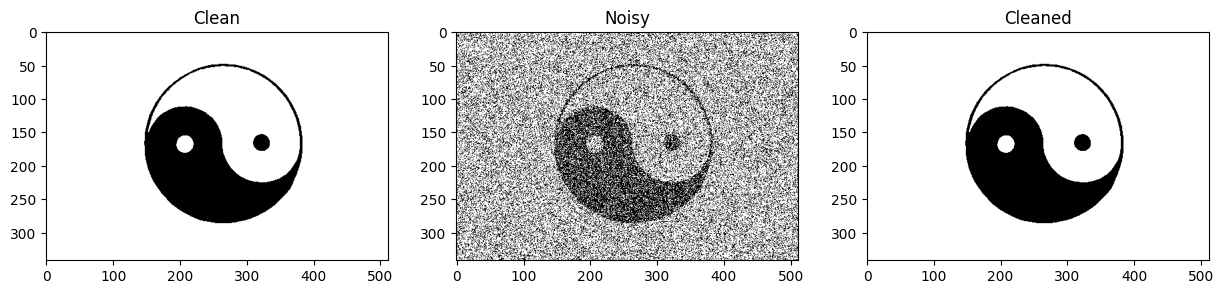

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train(self, pattern):
        pattern = pattern.reshape((self.size, 1))
        self.weights += np.dot(pattern, pattern.T)
        np.fill_diagonal(self.weights, 0)  # No self-connections

    def recall(self, noisy_pattern, max_iter=5):
        pattern = noisy_pattern.copy()
        for _ in range(max_iter):
            for i in range(self.size):
                pattern[i] = np.sign(np.dot(self.weights[i], pattern))
        return pattern

def process_image_blockwise(clean_path, noisy_path, block_size=32):
    # Load images
    clean_img = np.array(Image.open(clean_path).convert('L'))
    noisy_img = np.array(Image.open(noisy_path).convert('L'))

    # Pad images to make them divisible by block_size
    def pad_image(img):
        h, w = img.shape
        pad_h = (block_size - h % block_size) % block_size
        pad_w = (block_size - w % block_size) % block_size
        return np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant')

    clean_img = pad_image(clean_img)
    noisy_img = pad_image(noisy_img)

    # Binarize
    clean_img = np.where(clean_img > 128, 1, -1)
    noisy_img = np.where(noisy_img > 128, 1, -1)

    # Process blocks
    h, w = clean_img.shape
    cleaned_img = np.zeros_like(noisy_img)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            clean_block = clean_img[i:i+block_size, j:j+block_size]
            noisy_block = noisy_img[i:i+block_size, j:j+block_size]

            # Skip if block is smaller than expected (edge case)
            if clean_block.shape != (block_size, block_size):
                continue

            # Flatten and process
            block_flat = block_size * block_size
            clean_flat = clean_block.flatten()
            noisy_flat = noisy_block.flatten()

            hopfield = HopfieldNetwork(block_flat)
            hopfield.train(clean_flat)
            cleaned_flat = hopfield.recall(noisy_flat)
            cleaned_block = cleaned_flat.reshape((block_size, block_size))
            cleaned_img[i:i+block_size, j:j+block_size] = cleaned_block

    # Crop back to original dimensions (remove padding)
    original_h, original_w = np.array(Image.open(clean_path)).shape[:2]
    cleaned_img = cleaned_img[:original_h, :original_w]

    return clean_img[:original_h, :original_w], noisy_img[:original_h, :original_w], cleaned_img

# Usage
clean_img, noisy_img, cleaned_img = process_image_blockwise("/content/drive/MyDrive/Hopfield Network/Training/clean_image.jpg", "/content/drive/MyDrive/Hopfield Network/Testing/noisy_image.jpg")

# Plot results
plt.figure(figsize=(15, 5))
plt.imshow(clean_img, cmap='gray'); plt.title("Clean")
plt.imshow(noisy_img, cmap='gray'); plt.title("Noisy")
plt.imshow(cleaned_img, cmap='gray'); plt.title("Cleaned")
plt.show()

# **LAB-5 (Speech Recognition using RBM)**

In [ ]:
import os
import librosa
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# ----------------------
# STEP 1: Load Audio and Extract Features
# ----------------------
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

# ----------------------
# STEP 2: Load Dataset
# ----------------------
def load_dataset(dataset_dir):
    X = []
    y = []
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                if file.endswith('.wav'):
                    file_path = os.path.join(label_dir, file)
                    features = extract_features(file_path)
                    X.append(features)
                    y.append(label)
    return np.array(X), np.array(y)

# ----------------------
# STEP 3: Train RBM + Logistic Regression
# ----------------------
def train_model(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    rbm = BernoulliRBM(n_components=512, learning_rate=0.06, n_iter=200, verbose=True)
    logistic = LogisticRegression(max_iter=1000)

    model = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])
    model.fit(X_train_scaled, y_train)

    return model, scaler

# ----------------------
# STEP 4: Predict a New Audio File
# ----------------------
def predict_word(model, scaler, audio_file):
    features = extract_features(audio_file)
    features_scaled = scaler.transform([features])
    prediction = model.predict(features_scaled)
    return prediction[0]

# ----------------------
# MAIN FUNCTION
# ----------------------
if __name__ == "__main__":
    dataset_dir = "/content/drive/MyDrive/Speech Dataset/train/audio"
    test_audio = "/content/drive/MyDrive/Speech Dataset/Zero.wav"

    print("Loading dataset...")
    X, y = load_dataset(dataset_dir)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    print("Training RBM model...")
    model, scaler = train_model(X_train, y_train)

    # Evaluate on training set
    X_train_scaled = scaler.transform(X_train)
    y_train_pred = model.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Evaluate on test set
    X_test_scaled = scaler.transform(X_test)
    y_test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_test_pred)

Loading dataset...
Training RBM model...
[BernoulliRBM] Iteration 1, pseudo-likelihood = -117234.97, time = 3.89s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -246073.19, time = 5.57s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -352606.47, time = 7.39s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -485246.28, time = 5.45s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -592811.00, time = 7.03s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -726891.44, time = 5.38s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -852776.75, time = 6.40s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -941398.81, time = 6.00s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -1076098.25, time = 5.73s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -1176598.38, time = 7.11s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -1263947.12, time = 5.40s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -1411728.88, time = 6.89s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -1569071.62, time = 5.29s
[

In [ ]:
  print(f"\n Training Accuracy: {train_acc:.2f}%")
  print(f"Testing Accuracy: {test_acc:.2f}%")


 Training Accuracy: 76.45%
Testing Accuracy: 72.33%


In [ ]:
# Predict custom test audio
print("\nTesting on new audio...")
predicted_encoded = predict_word(model, scaler, test_audio)
predicted_label = label_encoder.inverse_transform([predicted_encoded])[0]
print(f"Predicted Word: {predicted_label}")


Testing on new audio...
Predicted Word: zero


# **Walking Style**

In [ ]:
# Step 1: Install unrar tool
!apt-get install unrar

# Step 2: Path of your .rar file
rar_file_path = "/content/drive/MyDrive/WalkingStyle/OUTD-B.rar"  # <-- Change this to your file's path
extract_to = "/content/drive/MyDrive/WalkingStyle"   # <-- Folder where files will be extracted

# Step 3: Create output directory if not exists
import os
os.makedirs(extract_to, exist_ok=True)

# Step 4: Extract the .rar file
!unrar x "{rar_file_path}" "{extract_to}/"

print("✅ Extraction complete.")

Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000056.png      97%  OK 
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000057.png      97%  OK 
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000058.png      97%  OK 
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000059.png      97%  OK 
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000060.png      97%  OK 
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000061.png      97%  OK 
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000062.png      97%  OK 
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000063.png      97%  OK 
Extracting  /content/drive/MyDrive/WalkingStyle/OUTD-B/00110M4000S0/00000064.png      97%  OK 
Extracting  /

In [3]:
# --------------------------------------------------
# 🔧 Step 1: Install & Setup Dependencies
# --------------------------------------------------
!pip install -q torch torchvision torchaudio opencv-python

import os
import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

#from detectron2.engine import DefaultPredictor
#from detectron2.config import get_cfg
#from detectron2 import model_zoo


# --------------------------------------------------
# 📦 Step 2: GEI Generation from Folder of Frames
# --------------------------------------------------
def generate_gei_from_folder(folder_path, output_size=(128, 128)):
    frame_paths = sorted(glob.glob(os.path.join(folder_path, '*.png')))
    frames = []
    for frame_path in frame_paths:
        img = cv2.imread(frame_path)
        person = extract_person_contour(img)
        gray = cv2.cvtColor(person, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, output_size)
        frames.append(resized)
    if not frames:
        return None
    gei = np.mean(frames, axis=0)
    return gei / 255.0



# --------------------------------------------------
# 🧍 Step 3: Setup Faster R-CNN for Pedestrian Detection (optional)
# --------------------------------------------------
def setup_faster_rcnn():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    return DefaultPredictor(cfg)

def extract_person_contour(image):
    """
    Approximate pedestrian detection using background subtraction and contour filtering.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fg_mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]

    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image  # return original if no contours

    # Get largest contour assuming it's the person
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    person = image[y:y+h, x:x+w]
    return person



# --------------------------------------------------
# 🧠 Step 4: CNN for Feature Extraction
# --------------------------------------------------
class GaitCNN(nn.Module):
    def __init__(self):
        super(GaitCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.conv(x).view(x.size(0), -1)


# --------------------------------------------------
# 🔁 Step 5: BLSTM for Sequence Classification
# --------------------------------------------------
class GaitRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GaitRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


# --------------------------------------------------
# 📊 Step 6: Full Pipeline with Dataset Folder
# --------------------------------------------------
class GaitDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


def load_dataset(main_folder, cnn_model):
    geis, labels = [], []
    label_map = {}
    id_list = sorted(os.listdir(main_folder))
    for i, folder_name in enumerate(id_list):
        person_folder = os.path.join(main_folder, folder_name)
        gei = generate_gei_from_folder(person_folder)
        if gei is None:
            continue
        label_map[folder_name] = i
        gei_tensor = torch.tensor(gei, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        with torch.no_grad():
            features = cnn_model(gei_tensor).squeeze().numpy()
        geis.append(features)
        labels.append(i)
    return np.array(geis), np.array(labels)


def train_and_test(main_folder):
    cnn = GaitCNN()
    features, labels = load_dataset(main_folder, cnn)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels)

    # RNN expects sequences, so expand dim (batch, seq_len, input_dim)
    X_train_seq = torch.tensor(X_train).unsqueeze(1).float()
    X_test_seq = torch.tensor(X_test).unsqueeze(1).float()
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    train_dataset = GaitDataset(X_train_seq, y_train)
    test_dataset = GaitDataset(X_test_seq, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

    model = GaitRNN(input_dim=X_train_seq.shape[2], hidden_dim=55, num_classes=len(set(labels)))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    # Training
    model.train()
    for epoch in range(10):
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Testing
    model.eval()
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch)
            y_pred.extend(outputs.argmax(dim=1).numpy())

    print("\n✅ Training Accuracy:", accuracy_score(y_train, model(X_train_seq).argmax(dim=1)))
    print("✅ Testing Accuracy:", accuracy_score(y_test, y_pred))


# ✅ Call the function with your dataset path
dataset_path = "/content/drive/MyDrive/WalkingStyle/OUTD-B"  # Change this to your folder path
train_and_test(dataset_path)

ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


KeyboardInterrupt: 